## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt, transforms
import random
import pandas as pd
# from Load_Recording_Data import LoadRecordingData, Recording     # (Use this for old data)
from load_recording_data import LoadRecordingData                 # (Use this for new data)
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import pysindy as ps
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.integrate import quad
import tensorflow as tf
import keras
from fastdtw import fastdtw
import itertools

2024-02-07 22:07:20.627923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 22:07:21.961834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-07 22:07:21.962527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-07 22:07:21.962538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
gpu_id = 2
tf.config.set_visible_devices(gpus[gpu_id], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


## Load data

In [3]:
intrasTrainVal, extrasTrainVal, intrasTest, extrasTest = LoadRecordingData()
idx_train, idx_val = train_test_split(np.arange(len(intrasTrainVal)), test_size=0.20) #, random_state=42)

extrasTrain = extrasTrainVal[idx_train]
intrasTrain = intrasTrainVal[idx_train]
extrasVal = extrasTrainVal[idx_val]
intrasVal = intrasTrainVal[idx_val]


# dataset = LoadRecordingData()
# extrasTrain = dataset['8k'].extras_training2
# intrasTrain = dataset['8k'].intras_training2
# extrasVal = dataset['8k'].extras_val2
# intrasVal = dataset['8k'].intras_val2
# extrasTest = dataset['8k'].extras_unseen2
# intrasTest = dataset['8k'].intras_unseen2

W5FebD1_10nM_Dofe_51_52_8000
W5FebD1_10nM_Dofe_57_58_8000
W5FebD1_10nM_Dofe_84_85_8000
W8FebD2_10nM_Dofe_57_47_8000
W8FebD2_10nM_Dofe_84_74_8000
W8FebD3_10nM_Dofe_24_14_8000
W8FebD3_10nM_Dofe_61_62_8000


## Helper functions

In [4]:
# Takes in a 1-dimensional array and a window size, and applies a moving
# average filter to data.
def moving_filter(data, window_size):
    i = 0
    moving_averages = []
    while i < len(data) - window_size + 1:
        this_window = data[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    for i in range(window_size - 1):
        ind = len(data) - (window_size - i)
        moving_averages.append(np.mean(data[ind-window_size:ind]))

    return moving_averages

def mse(y, p):
    return np.mean((y-p)**2)

def mae(y, p):
    return np.mean(np.absolute(y-p))

def dtw(y, p):
    distances = []
    
    for i in range(len(y)):
        dist, _ = fastdtw(y[i], p[i])
        distances.append(dist)
        
    return np.mean(np.array(distances))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

### Smooth the data by applying moving filter

In [5]:
# Apply moving filter on intras and extras
# Training set
windowSize = 20
temp = []

for rec in intrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
intrasTrain = np.array(temp)
temp = []

for rec in extrasTrain:
    temp.append(moving_filter(rec, windowSize))
    
extrasTrain = np.array(temp)

# Validation set
temp = []

for rec in intrasVal:
    temp.append(moving_filter(rec, windowSize))
    
intrasVal = np.array(temp)
temp = []

for rec in extrasVal:
    temp.append(moving_filter(rec, windowSize))
    
extrasVal = np.array(temp)


# Test set
temp = []

for rec in intrasTest:
    temp.append(moving_filter(rec, windowSize))
    
intrasTest = np.array(temp)
temp = []

for rec in extrasTest:
    temp.append(moving_filter(rec, windowSize))
    
extrasTest = np.array(temp)

### Function to extract features

In [6]:
def GetFeatures(intras, extras):
    XBefore = []
    XAfter = []
    YBefore = []
    YAfter = []
    indicesBefore = []
    indicesAfter = []
    windowSize = 20
    
    featureNames = ['d2eAP', 'deAP', 'eAP', 't'] #, 'exp(d2eAP)', 'exp(deAP)', 'exp(eAP)', 't']#, 'distFromMax', 'distFromMin']
    s = [i for i in range(len(featureNames))]
    combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
    featureCombs = []
    
    for comb in combs[1:]:
        for tpl in comb:
            name = ""

            for ind in tpl:
                name += "*"+featureNames[ind]

            featureCombs.append(name)
            
    t = np.array([i for i in range(len(extras[0]))])/len(extras[0])
    
    for i in range(len(extras)):
        iAP = intras[i]
        diAP = np.array(moving_filter(np.gradient(iAP), windowSize))
        d2iAP = np.array(moving_filter(np.gradient(diAP), windowSize))

        eAP = extras[i]
        deAP = np.array(moving_filter(np.gradient(eAP), windowSize))
        d2eAP = np.array(moving_filter(np.gradient(deAP), windowSize))
        
        breakInd = np.argmax(eAP[:1500])
            
#         iAP = intras[i]
#         diAP = np.gradient(iAP)
#         d2iAP = np.gradient(diAP)

#         eAP = extras[i]
#         deAP = np.gradient(eAP)
#         d2eAP = np.gradient(deAP)

        featureList1 = [d2eAP[:breakInd], deAP[:breakInd], eAP[:breakInd], t[:breakInd]] #np.exp(d2eAP)[:breakInd], np.exp(deAP)[:breakInd], np.exp(eAP)[:breakInd], t[:breakInd]]
        featureList2 = [d2eAP[breakInd:], deAP[breakInd:], eAP[breakInd:], t[breakInd:]] #np.exp(d2eAP)[breakInd:], np.exp(deAP)[breakInd:], np.exp(eAP)[breakInd:], t[breakInd:]]
            
        featureMatrix1 = []
        featureMatrix2 = []
        
        for comb in combs[1:]:
            for tpl in comb:
                feature1 = 1
                feature2 = 1
                
                for ind in tpl:
                    feature1 = feature1*featureList1[ind]
                    feature2 = feature2*featureList2[ind]
                    
                featureMatrix1.append(feature1)
                featureMatrix2.append(feature2)
        
        start = int(len(XBefore))
        XBefore.extend(np.array(featureMatrix1).T)
        end = int(len(XBefore))-1
        indicesBefore.append([start, end])
        
        start = int(len(XAfter))
        XAfter.extend(np.array(featureMatrix2).T)
        end = int(len(XAfter))-1
        indicesAfter.append([start, end])
        
        YBefore.extend(iAP[:breakInd])
        YAfter.extend(iAP[breakInd:])
        
    XBefore = np.array(XBefore)
    XAfter = np.array(XAfter)
    YBefore = np.array(YBefore)
    YAfter = np.array(YAfter)
     
    return XBefore, XAfter, YBefore, YAfter, indicesBefore, indicesAfter

### Extract features from training data

In [7]:
XBefore, XAfter, YBefore, YAfter, indicesBefore, indicesAfter = GetFeatures(intrasTrain, extrasTrain)
scalerBefore = StandardScaler()
scalerAfter = StandardScaler()
# scalerY0 = StandardScaler()

XBefore = scalerBefore.fit_transform(XBefore)
XAfter = scalerAfter.fit_transform(XAfter)
# Y0 = scalerY0.fit_transform(Y0.reshape(-1, 1)).reshape(-1)

### Extract features from validation and test data for hyperparam tuning and evaluation

In [8]:
X_valBefore, X_valAfter, Y_valBefore, Y_valAfter, indicesBefore_val, indicesAfter_val = GetFeatures(intrasVal, extrasVal)
X_valBefore = scalerBefore.transform(X_valBefore)
X_valAfter = scalerAfter.transform(X_valAfter)
# Y_val0 = scalerY0.transform(Y_val0.reshape(-1, 1)).reshape(-1)

In [9]:
X_testBefore, X_testAfter, Y_testBefore, Y_testAfter, indicesBefore_test, indicesAfter_test = GetFeatures(intrasTest, extrasTest)
X_testBefore = scalerBefore.transform(X_testBefore)
X_testAfter = scalerAfter.transform(X_testAfter)

### Linear Regression model using Scikit and Lasso selection

In [10]:
lamda1 = 0.01
lamda2 = 0.01

selector1 = SelectFromModel(Lasso(alpha=lamda1, random_state=10))
selector2 = SelectFromModel(Lasso(alpha=lamda2, random_state=10))

selector1.fit(XBefore, YBefore)
selector2.fit(XAfter, YAfter)

print(selector1.get_support())
print(selector2.get_support())

XBefore_selected = selector1.transform(XBefore)
XAfter_selected = selector2.transform(XAfter)

reg_selected1 = Lasso(alpha=lamda1, random_state=10).fit(XBefore_selected, YBefore)
reg_selected2 = Lasso(alpha=lamda2, random_state=10).fit(XAfter_selected, YAfter)

print(reg_selected1.coef_)
print(reg_selected1.intercept_)

print(reg_selected2.coef_)
print(reg_selected2.intercept_)

# predTrain = reg_selected.predict(X_selected)
# print("MSE on train with reg_selected", mse(predTrain, Y))
# print("MAE on train with reg_selected", mae(predTrain, Y))

[False False  True False False False False False False  True False False
 False False False]
[False False False  True False False False False False  True False False
 False  True False]
[0.00476949 0.01119521]
0.14219660994228364
[-0.31447902  0.00047627  0.0102037 ]
0.44779654235834426


### Evaluate model on validation data

In [ ]:
valOut = []
for i in range(len(indicesBefore_val)):
    valOut1 = reg_selected1.predict(selector1.transform(X_valBefore[indicesBefore_val[i][0]:indicesBefore_val[i][1]+1])).reshape((-1))
    valOut2 = reg_selected2.predict(selector2.transform(X_valAfter[indicesAfter_val[i][0]:indicesAfter_val[i][1]+1])).reshape((-1))
    valOut.extend(np.concatenate([valOut1, valOut2], 0))
    
valOut = np.array(valOut)

# predd2_selected = np.reshape(valOut, (-1, 8000))

# predd1_selected = np.reshape(valOut, (-1, 8000))
# predd1_selected = np.cumsum(predd2_selected, axis=1)

prediAP_selected = np.reshape(valOut, (-1, 8000))
# prediAP_selected = np.cumsum(predd1_selected, axis=1)

yiAP = intrasVal

print("MSE on val d0 with reg_selected", mse(prediAP_selected, yiAP))
print("MAE on val d0 with reg_selected", mae(prediAP_selected, yiAP))
print("DTW on val d0 with reg_selected", dtw(prediAP_selected, yiAP))

In [ ]:
featureNames = ['d2eAP', 'deAP', 'eAP', 't'] #, 'np.exp(d2eAP)', 'np.exp(deAP)', 'np.exp(eAP)', 't']#, 'distFromMax', 'distFromMin']
s = [i for i in range(len(featureNames))]
combs = [list(itertools.combinations(s, r)) for r in range(len(s)+1)]
featureCombs = []

for comb in combs[1:]:
    for tpl in comb:
        name = ""

        for ind in tpl:
            name += "*"+featureNames[ind]

        featureCombs.append(name)

#### Only for weight params
# featureCombs.extend(["max"+str(i) for i in range(-50, 50)])
# featureCombs.extend(["min"+str(i) for i in range(100)])
####

print(np.array(featureCombs)[selector1.get_support()])
print(np.array(featureCombs)[selector2.get_support()])

### Evaluate model on test data

In [11]:
testOut = []
for i in range(len(indicesBefore_test)):
    testOut1 = reg_selected1.predict(selector1.transform(X_testBefore[indicesBefore_test[i][0]:indicesBefore_test[i][1]+1])).reshape((-1))
    testOut2 = reg_selected2.predict(selector2.transform(X_testAfter[indicesAfter_test[i][0]:indicesAfter_test[i][1]+1])).reshape((-1))
    testOut.extend(np.concatenate([testOut1, testOut2], 0))
    
testOut = np.array(testOut)

# predd2_selected = np.reshape(testOut, (-1, 8000))

# predd1_selected = np.reshape(testOut, (-1, 8000))
# predd1_selected = np.cumsum(predd2_selected, axis=1)

prediAP_selected = np.reshape(testOut, (-1, 8000))
# prediAP_selected = np.cumsum(predd1_selected, axis=1)


yiAP = intrasTest

print("MSE on test d0 with reg_selected", mse(prediAP_selected, yiAP))
print("MAE on test d0 with regselected", mae(prediAP_selected, yiAP))
print("DTW on test d0 with reg_selected", dtw(prediAP_selected, yiAP))

MSE on test d0 with reg_selected 0.005934238759531112
MAE on test d0 with regselected 0.06117817746970325
DTW on test d0 with reg_selected 44.64179899276059


In [ ]:
# 219, 133, 48
import pickle
diAP_physics_piecewise = {}

### Choose a recording at random from the test set

In [26]:
ind = 5#random.randint(0, len(extrasTest))#219, 133, 48
print(ind)

xBefore = selector1.transform(X_testBefore)[indicesBefore_test[ind][0]:indicesBefore_test[ind][1]]
xAfter = selector2.transform(X_testAfter)[indicesAfter_test[ind][0]:indicesAfter_test[ind][1]]
yBefore = Y_testBefore[indicesBefore_test[ind][0]:indicesBefore_test[ind][1]]
yAfter = Y_testAfter[indicesAfter_test[ind][0]:indicesAfter_test[ind][1]]

5


### Get model prediction for the chosen recording

In [27]:
out1 = reg_selected1.predict(xBefore)
# out1 = tf.reshape(out1, (-1)).numpy()
out2 = reg_selected2.predict(xAfter)
# out2 = tf.reshape(out2, (-1)).numpy()
pred = np.concatenate((out1, out2))
# pred = reg_selected.predict(x)
# pred1 = reg1.predict(x1)

### Prediction plots

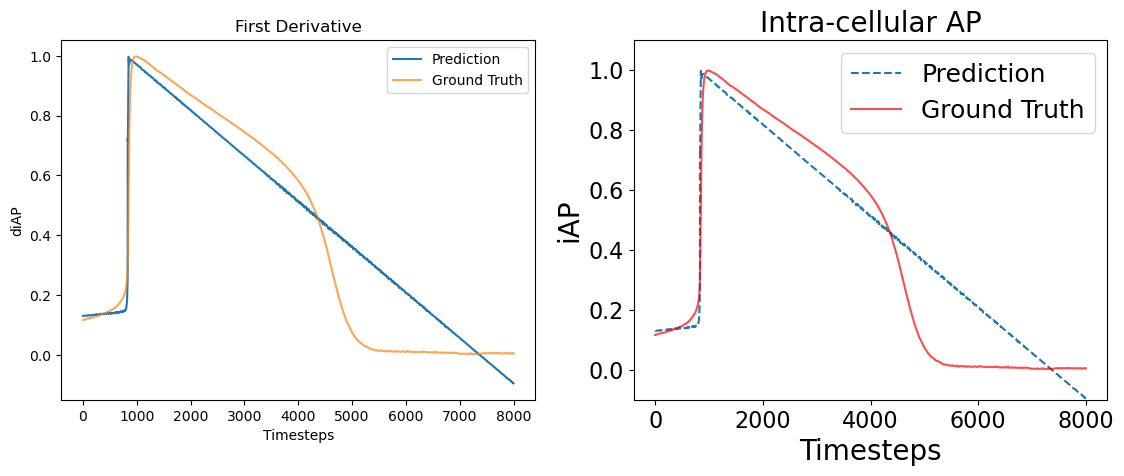

In [28]:
transparency = 0.7
fig0, ax0 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig0.tight_layout(pad=4)

# Plot second derivative
ax0[0].plot(pred)
ax0[0].plot(intrasTest[ind], alpha=transparency)
ax0[0].legend(['Prediction', 'Ground Truth'])
ax0[0].title.set_text("First Derivative")
ax0[0].set_xlabel("Timesteps")
ax0[0].set_ylabel("diAP")

# Plot first derivative
ax0[1].plot(pred, linestyle='dashed')
# ax0[1].plot(moving_filter(np.gradient(intrasTest[ind]), windowSize), alpha=transparency)
ax0[1].plot(intrasTest[ind], alpha=transparency, color='red')
ax0[1].legend(['Prediction', 'Ground Truth'], prop={'size': 18})
ax0[1].title.set_text("Intra-cellular AP")
ax0[1].title.set_fontsize(20)
ax0[1].set_xlabel("Timesteps", fontsize=20)
ax0[1].set_ylabel("iAP", fontsize=20)
ax0[1].set_ylim([-0.1, 1.1])
ax0[1].tick_params(axis='x', labelsize=16)
ax0[1].tick_params(axis='y', labelsize=16)

# Plot iAP
# ax0[2].plot(np.cumsum(np.cumsum(pred)))
# ax0[2].plot(intrasVal[ind], alpha=transparency)
# ax0[2].legend(['Prediction', 'Ground Truth'])
# ax0[2].title.set_text("Intra-cellular AP")
# ax0[2].set_xlabel("Timesteps")
# ax0[2].set_ylabel("iAP")

In [ ]:
diAP_physics_piecewise[48] = [np.cumsum(pred), intrasTest[ind]]

In [ ]:
diAP_physics_piecewise

In [ ]:
with open('diAP_physics_piecewise.pkl', 'wb') as fl:
    pickle.dump(diAP_physics_piecewise, fl)